In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ECG_function import *
%matplotlib inline

# "Naive" Wavelet Transformation
## Data Importing

In [2]:
Xtrain,Ytrain,Xtest = DataImporting()
lable = Ytrain.TARGET.values

In [3]:
#test
DataSample(Xtrain,[1,2],1)

,ML1_0,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML1_6,ML1_7,ML1_8,ML1_9,...,ML1_740,ML1_741,ML1_742,ML1_743,ML1_744,ML1_745,ML1_746,ML1_747,ML1_748,ML1_749
1,0.018403,0.026159,0.009684,0.001014,-0.000866,0.002019,0.000617,-0.011167,-0.026314,-0.026881,...,-0.030683,-0.027179,-0.023822,-0.021767,-0.021504,-0.022533,-0.023832,-0.023974,-0.021915,-0.017584
2,-0.020974,-0.044294,-0.044097,-0.042136,-0.041125,-0.034392,-0.033026,-0.031817,-0.032347,-0.034317,...,0.013544,-0.013377,-0.038524,-0.038650,-0.039073,-0.051832,-0.069153,-0.081822,-0.086272,-0.088153


## Feature Collection
We consider a fft transformation for all the 12 channels's signals.

(1000, 24, 376)
(1000, 9024)


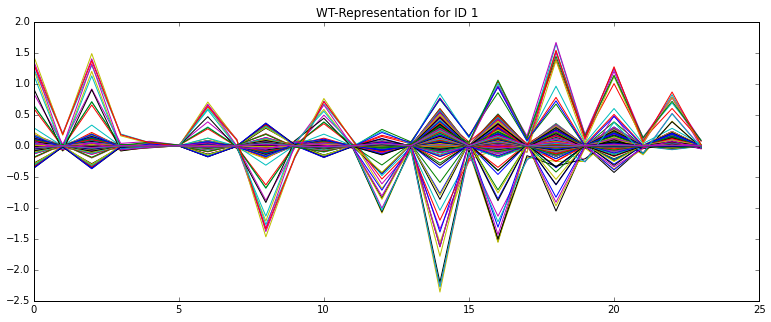

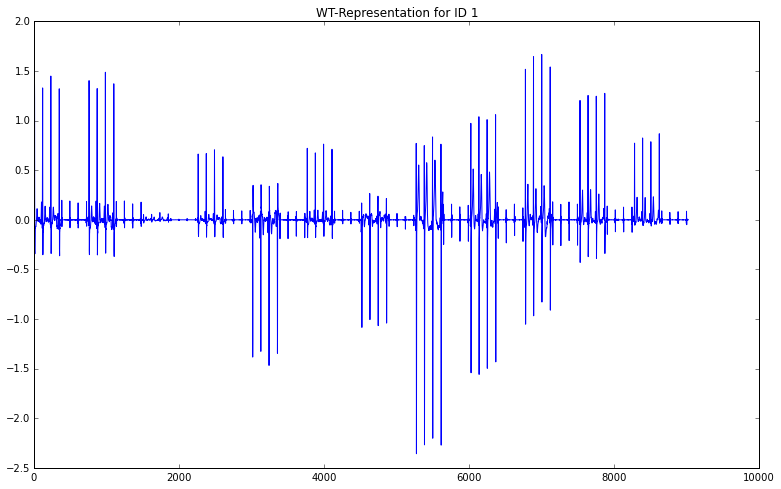

In [97]:
import pywt

AllFeatures_wt =[[] for i in range(1000)]
for id in range(1000):
    for k in range(1,13):
        AllFeatures_wt[id] += list(pywt.dwt(DataSample(Xtrain,id,k).values, 'db2'))
#test for id 1
plt.figure(figsize=(13,5))
plt.plot(AllFeatures_wt[1])
plt.title("WT-Representation for ID 1")
print np.shape(AllFeatures_wt)
import itertools
for id in range(1000):
    AllFeatures_wt[id] = list(itertools.chain(*AllFeatures_wt[id]))
print np.shape(AllFeatures_wt)
plt.figure(figsize=(13,8))
plt.plot(AllFeatures_wt[1])
plt.title("WT-Representation for ID 1")

## Feature Selction
We will use a classic F-test method.

In [98]:
from sklearn.feature_selection import SelectKBest, f_classif

Select = SelectKBest(f_classif, k=300)
SelectedFeatures = Select.fit_transform(AllFeatures_wt, lable)
np.shape(SelectedFeatures)

(1000, 300)

# Classification
## Gaussian NB

In [99]:
from sklearn.naive_bayes import GaussianNB 

N_sep = len(lable)*2/3

gnb = GaussianNB()
gnb.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print gnb.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_gnb = gnb.predict(SelectedFeatures[N_sep:])

0.631736526946


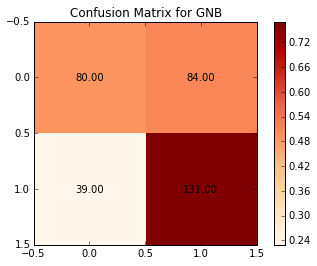

In [100]:
PlotCM(lable[N_sep:],feat_pred_gnb,'GNB')

## SVM
We select the kernel linear.

In [101]:
from sklearn import svm
svm = svm.SVC(kernel='linear')#‘linear!!!’ or 'poly'
svm.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print svm.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_svm = svm.predict(SelectedFeatures[N_sep:])

0.655688622754


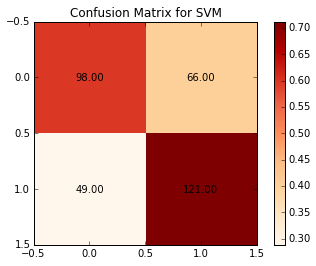

In [102]:
PlotCM(lable[N_sep:],feat_pred_svm,'SVM')

## Random Forest
We set the n_estimetors = 500.

In [103]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=200)
RF.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print RF.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_rf = RF.predict(SelectedFeatures[N_sep:])

0.694610778443


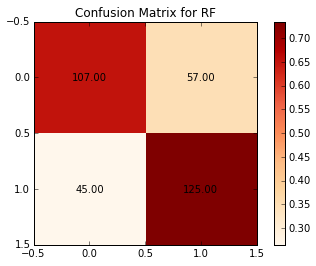

In [104]:
PlotCM(lable[N_sep:],feat_pred_rf,'RF')

## BenchMark for Different Number of Features

In [47]:
k_gnb = []
k_svm = []
k_rf = []

for num_feature in range(100,2000,100):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(AllFeatures_wt, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    


In [48]:
BenchMark = pd.DataFrame({"GNB":k_gnb,"SVM":k_svm,'RF':k_rf})
BenchMark.index = ["k = "+ str(i) for i in range(100,2000,100)]
BenchMark

,GNB,RF,SVM
k = 100,0.637725,0.691617,0.646707
k = 200,0.628743,0.697605,0.667665
k = 300,0.631737,0.691617,0.655689
k = 400,0.634731,0.706587,0.637725
k = 500,0.640719,0.706587,0.619760
k = 600,0.631737,0.703593,0.655689
k = 700,0.613772,0.700599,0.631737
k = 800,0.622754,0.709581,0.652695
k = 900,0.610778,0.715569,0.646707
k = 1000,0.613772,0.721557,0.628743


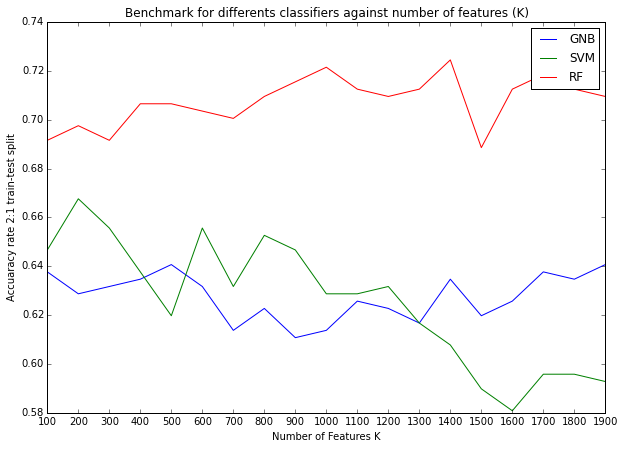

In [49]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark["GNB"])
plt.plot(BenchMark["SVM"])
plt.plot(BenchMark["RF"])
plt.xticks(range(0,19),range(100,2000,100))
plt.legend(['GNB','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")

In [69]:
k_gnb = []
k_svm = []
k_rf = []

for num_feature in range(10,200,10):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(AllFeatures_wt, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    

In [70]:
BenchMark2 = pd.DataFrame({"GNB":k_gnb,"SVM":k_svm,'RF':k_rf})
BenchMark2.index = ["k = "+ str(i) for i in range(10,200,10)]
BenchMark2

,GNB,RF,SVM
k = 10,0.565868,0.640719,0.583832
k = 20,0.595808,0.646707,0.622754
k = 30,0.598802,0.706587,0.646707
k = 40,0.610778,0.703593,0.670659
k = 50,0.613772,0.691617,0.673653
k = 60,0.625749,0.697605,0.697605
k = 70,0.631737,0.697605,0.697605
k = 80,0.640719,0.688623,0.682635
k = 90,0.643713,0.685629,0.664671
k = 100,0.637725,0.694611,0.646707


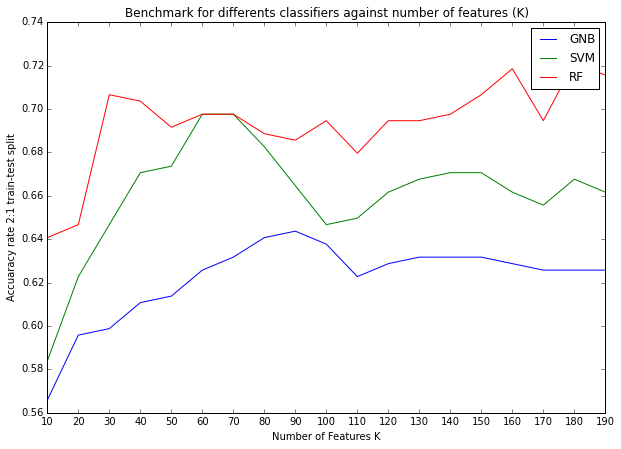

In [105]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark2["GNB"])
plt.plot(BenchMark2["SVM"])
plt.plot(BenchMark2["RF"])
plt.xticks(range(0,19),range(10,200,10))
plt.legend(['GNB','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")

### With these plots, we consider of using the algorithm RF with K = 300.

## Cross-Validation

In [81]:
from sklearn import cross_validation
scores  = cross_validation.cross_val_score(RF, SelectedFeatures, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.74257426  0.76237624  0.71        0.78        0.83        0.67        0.76
  0.73        0.67676768  0.66666667]
0.732838483848
